### Import libraries for experiments

In [5]:
import torch
from training_main import training_main, test
from utils import data_loading, normalization, filter_extraction, plot_results

import numpy as np
import pandas as pd

## Data Loading and Normalization

In [2]:
# LOAD DATA
train_data, train_labels, test_data, test_labels = data_loading("./data/train/", "./data/test/")
data = train_data + test_data

# NORMALIZATION
data_transform = normalization(data)

Red ch mean =  0.2083131469710406 
Green ch mean =  0.2082495726805566 
Blue ch mean =  0.2082443113461869
Red ch std =  0.21239369173135 
Green ch std =  0.2123701408982801 
Blue ch std =  0.2123710677526386


## CNN Training

In [6]:
MODEL_NAME = 'CNN'
NUM_FOLD = 10
num_epochs = 20

In [7]:
# TESTING

from CNN import CNN

max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))
model_CNN = CNN(input_channel=3, num_classes=2)
model_CNN.load_state_dict(checkpoint["model_state_dict"])

for parameter in model_CNN.parameters():
    parameter.requires_grad = False


In [5]:
model_CNN

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

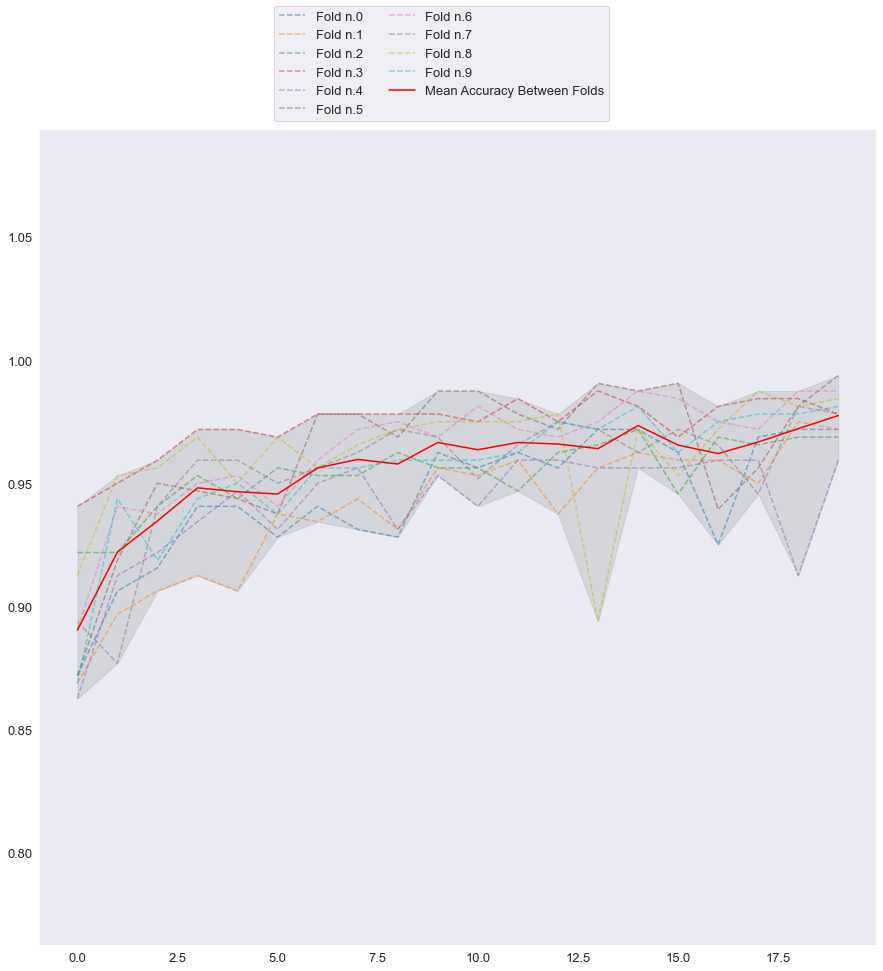

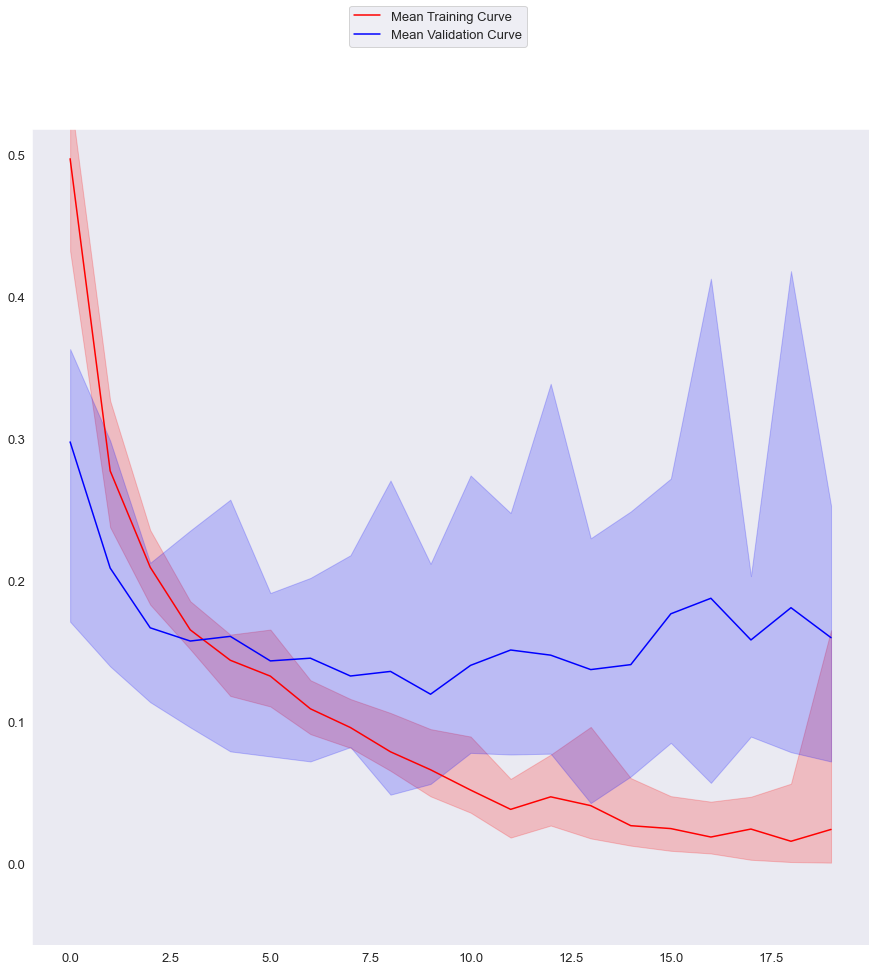

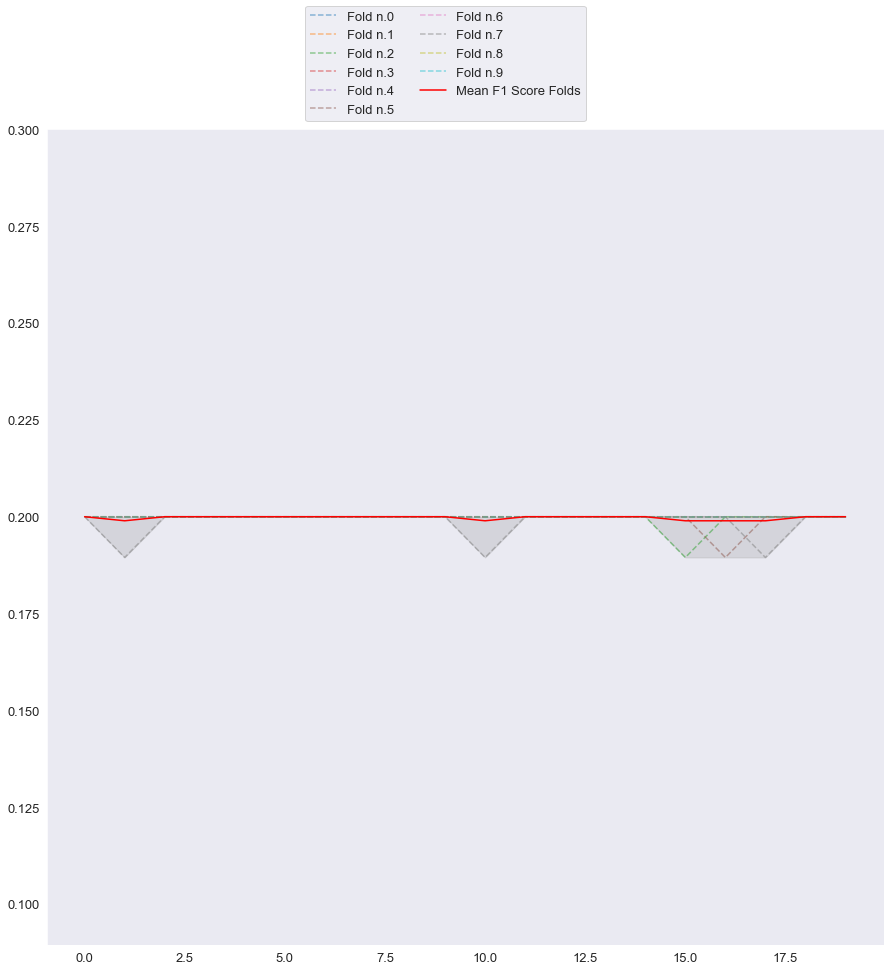

In [8]:
from utils import plot_results

# PLOTTING


val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

Accuracy 0.9733333333333334


<Figure size 504x360 with 0 Axes>

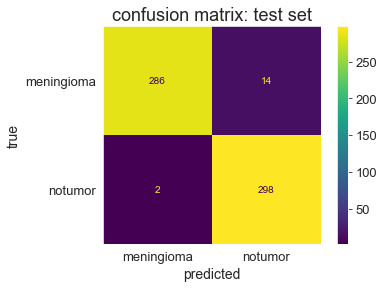

In [7]:
# TESTING - to correct

from training_main import test

acc_CNN = test(data_transform, test_data, test_labels, model_CNN, MODEL_NAME, device='cpu')
print("Accuracy", acc_CNN)


## Extract Filters from CNN

In [7]:
# Load the model on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN = model_CNN.to(device)

Filter extraction
Chosen image: 5101311705_3e5526d521_o.jpg
Total convolution layers: 4
Image shape before: torch.Size([3, 128, 128])
Image shape after: torch.Size([1, 3, 128, 128])


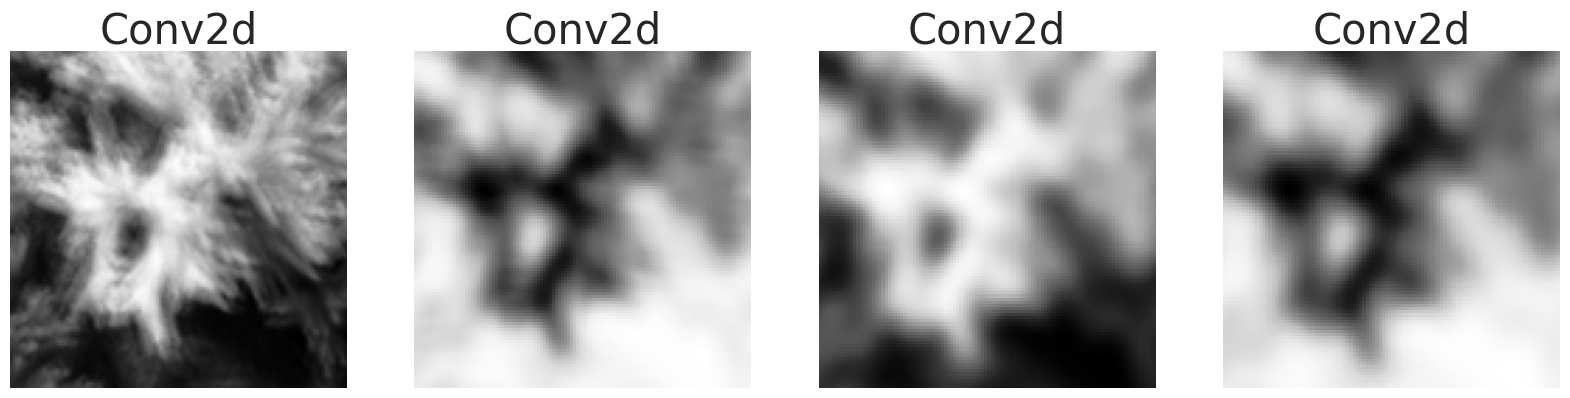

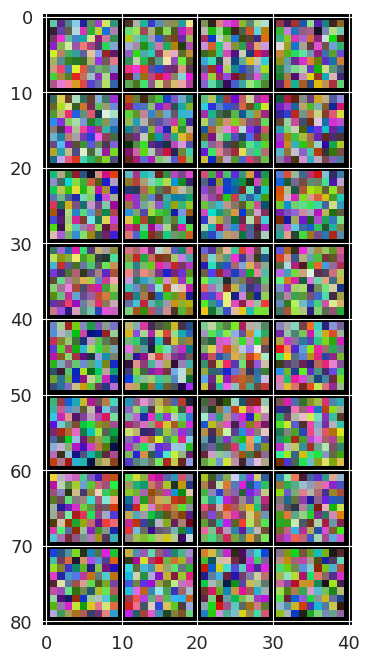

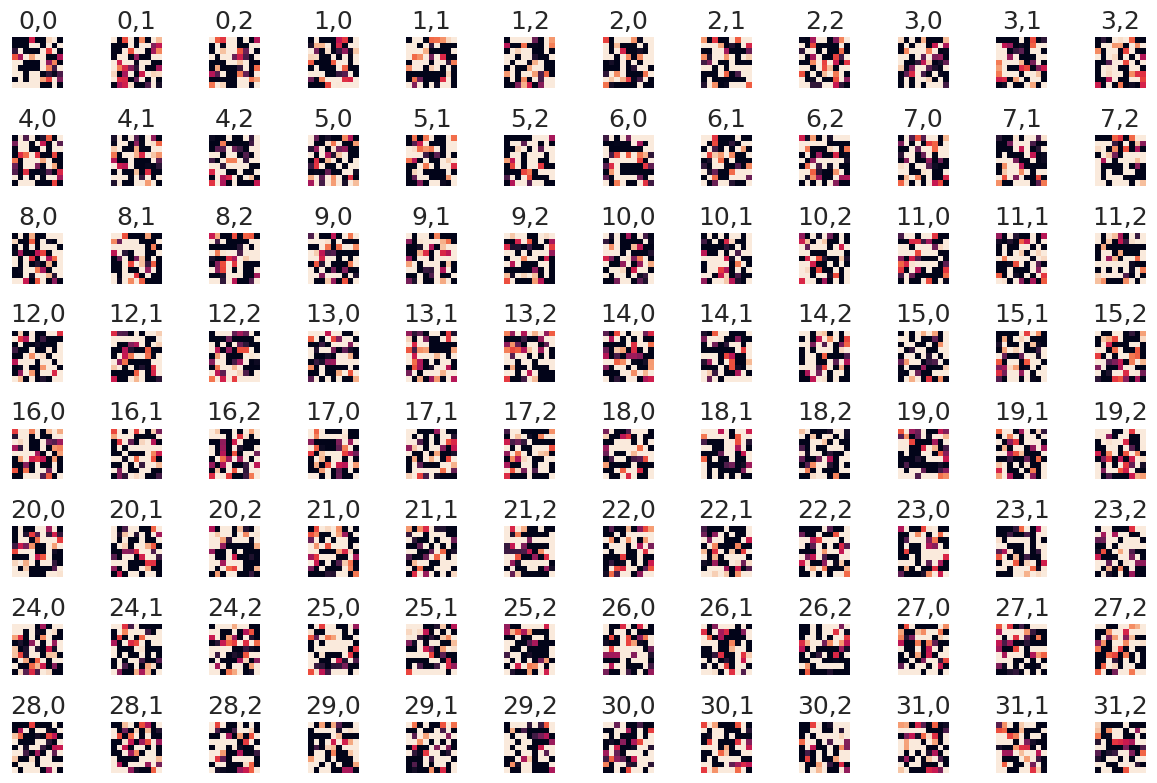

In [8]:
filter_extraction(model_CNN, data_transform, MODEL_NAME)

## ScatNet Training

In [9]:
MODEL_NAME = 'ScatNet'

In [11]:
# TRAINING
model_ScatNet = training_main(data_transform, train_data, train_labels, MODEL_NAME)

# TESTING
#acc_ScatNet = test(data_transform, test_data, test_labels, model_ScatNet, MODEL_NAME, device='cpu')
#print("Accuracy", acc_ScatNet)

Folding done!
Device:  cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 548.00 MiB. GPU 0 has a total capacty of 1.96 GiB of which 224.69 MiB is free. Including non-PyTorch memory, this process has 1.73 GiB memory in use. Of the allocated memory 1.64 GiB is allocated by PyTorch, and 30.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Extract Filters from ScatNet

In [ ]:
# EXTRACTION OF FILTERS
filter_extraction(model_ScatNet, data_transform, MODEL_NAME)